In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, accuracy_score, f1_score,  precision_score, recall_score, confusion_matrix
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.impute import SimpleImputer
from itertools import combinations
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_selection import mutual_info_classif

d:\work\DataScience\cs6010_fa2024_project_g06\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


In [2]:
df_1 = pd.read_parquet('../data/raw/yellow_tripdata_2024-01.parquet')
df_2 = pd.read_parquet('../data/raw/yellow_tripdata_2024-02.parquet')
df_3 = pd.read_parquet('../data/raw/yellow_tripdata_2024-03.parquet')
df_4 = pd.read_parquet('../data/raw/yellow_tripdata_2024-04.parquet')
df_5 = pd.read_parquet('../data/raw/yellow_tripdata_2024-05.parquet')
df_6 = pd.read_parquet('../data/raw/yellow_tripdata_2024-06.parquet')

df = pd.concat([df_1, df_2, df_3, df_4, df_5, df_6])

In [3]:
def downcast_dtypes(df):
    # Downcast numerical columns to save memory
    float_cols = df.select_dtypes(include=['float64']).columns
    int_cols = df.select_dtypes(include=['int64']).columns

    df[float_cols] = df[float_cols].astype(np.float32)
    df[int_cols] = df[int_cols].astype(np.int16)

    return df

def preprocess_data(df):
    # for NaN value
    df['passenger_count'] = pd.to_numeric(df['passenger_count'], errors='coerce')
    df['RatecodeID'] = pd.to_numeric(df['RatecodeID'], errors='coerce')
    df['congestion_surcharge'] = pd.to_numeric(df['congestion_surcharge'], errors='coerce')
    df['Airport_fee'] = pd.to_numeric(df['Airport_fee'], errors='coerce')
    
    # Handle missing values
    numeric_columns = df.select_dtypes(include=['int64', 'float64']).columns
    imputer = SimpleImputer(strategy='median')
    df[numeric_columns] = imputer.fit_transform(df[numeric_columns])
    
    # Downcast dtypes
    df = downcast_dtypes(df)
    
    # Feature Engineering
    df['pickup_hour'] = pd.to_datetime(df['tpep_pickup_datetime']).dt.hour
    df['pickup_day'] = pd.to_datetime(df['tpep_pickup_datetime']).dt.day_name()
    df['pickup_month'] = pd.to_datetime(df['tpep_pickup_datetime']).dt.month
    
    # Encode categorical variables
    categorical_columns = ['pickup_day', 'RatecodeID']
    df = pd.get_dummies(df, columns=categorical_columns)
    
    return df


In [4]:
df = preprocess_data(df)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 20332093 entries, 0 to 3539192
Data columns (total 34 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   VendorID               int32         
 1   tpep_pickup_datetime   datetime64[us]
 2   tpep_dropoff_datetime  datetime64[us]
 3   passenger_count        float32       
 4   trip_distance          float32       
 5   store_and_fwd_flag     object        
 6   PULocationID           int32         
 7   DOLocationID           int32         
 8   payment_type           float32       
 9   fare_amount            float32       
 10  extra                  float32       
 11  mta_tax                float32       
 12  tip_amount             float32       
 13  tolls_amount           float32       
 14  improvement_surcharge  float32       
 15  total_amount           float32       
 16  congestion_surcharge   float32       
 17  Airport_fee            float32       
 18  pickup_hour            int

In [5]:
pd.DataFrame({
    'feature': df.columns.values,
    'data_type': df.dtypes.values,
    'null_value(%)': df.isna().mean().values * 100,
    'neg_value(%)': [len(df[col][df[col] < 0]) / len(df) * 100 if col in df.select_dtypes(include=[np.number]).columns else 0 for col in df.columns],
    '0_value(%)': [len(df[col][df[col] == 0]) / len(df) * 100 if col in df.select_dtypes(include=[np.number]).columns else 0 for col in df.columns],
    'duplicate' : df.duplicated().sum(),
    'min': [df[col].min() if col in df.select_dtypes(include=[np.number]).columns else None for col in df.columns],
    'max': [df[col].max() if col in df.select_dtypes(include=[np.number]).columns else None for col in df.columns],
    'n_unique': df.nunique().values,
    'sample_unique': [df[col].unique() for col in df.columns]}
).round(3)

,feature,data_type,null_value(%),neg_value(%),0_value(%),duplicate,min,max,n_unique,sample_unique
0,VendorID,int32,0.000,0.000,0.000,1,1.00,6.000,3,"[2, 1, 6]"
1,tpep_pickup_datetime,datetime64[us],0.000,0.000,0.000,1,NaN,NaN,9955675,"[2024-01-01 00:57:55, 2024-01-01 00:03:00, 202..."
2,tpep_dropoff_datetime,datetime64[us],0.000,0.000,0.000,1,NaN,NaN,9948395,"[2024-01-01 01:17:43, 2024-01-01 00:09:36, 202..."
3,passenger_count,float32,0.000,0.000,1.087,1,0.00,9.000,10,"[1.0, 2.0, 0.0, 4.0, 3.0, 5.0, 6.0, 8.0, 7.0, ..."
4,trip_distance,float32,0.000,0.000,1.792,1,0.00,312722.312,7056,"[1.72, 1.8, 4.7, 1.4, 0.8, 10.82, 3.0, 5.44, 0..."
5,store_and_fwd_flag,object,9.719,0.000,0.000,1,NaN,NaN,2,"[N, Y, None]"
6,PULocationID,int32,0.000,0.000,0.000,1,1.00,265.000,262,"[186, 140, 236, 79, 211, 148, 138, 246, 161, 1..."
7,DOLocationID,int32,0.000,0.000,0.000,1,1.00,265.000,261,"[79, 236, 211, 148, 141, 181, 231, 261, 113, 1..."
8,payment_type,float32,0.000,0.000,9.719,1,0.00,5.000,6,"[2.0, 1.0, 4.0, 3.0, 0.0, 5.0]"
9,fare_amount,float32,0.000,1.553,0.041,1,-1285.40,334076.312,14681,"[17.7, 10.0, 23.3, 7.9, 29.6, 45.7, 25.4, 31.0..."


### Handling Duplicates

In [6]:
df[df.duplicated()]

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,...,pickup_day_Thursday,pickup_day_Tuesday,pickup_day_Wednesday,RatecodeID_1.0,RatecodeID_2.0,RatecodeID_3.0,RatecodeID_4.0,RatecodeID_5.0,RatecodeID_6.0,RatecodeID_99.0
754252,2,2024-02-08 18:23:50,2024-02-08 18:38:14,1.0,0.81,N,162,230,1.0,12.8,...,True,False,False,True,False,False,False,False,False,False


In [7]:
df.drop_duplicates(inplace= True)

In [8]:
duplicate_value = df[df.duplicated(subset=['tpep_pickup_datetime', 'tpep_dropoff_datetime', 'passenger_count', 'trip_distance'], keep=False)]
duplicate_value

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,...,pickup_day_Thursday,pickup_day_Tuesday,pickup_day_Wednesday,RatecodeID_1.0,RatecodeID_2.0,RatecodeID_3.0,RatecodeID_4.0,RatecodeID_5.0,RatecodeID_6.0,RatecodeID_99.0
99,2,2024-01-01 00:18:24,2024-01-01 00:30:39,1.0,2.16,N,249,232,4.0,-13.500000,...,False,False,False,True,False,False,False,False,False,False
100,2,2024-01-01 00:18:24,2024-01-01 00:30:39,1.0,2.16,N,249,232,4.0,13.500000,...,False,False,False,True,False,False,False,False,False,False
506,2,2024-01-01 00:04:00,2024-01-01 00:04:44,1.0,0.01,N,63,63,2.0,-31.500000,...,False,False,False,False,False,False,False,True,False,False
507,2,2024-01-01 00:04:00,2024-01-01 00:04:44,1.0,0.01,N,63,63,2.0,31.500000,...,False,False,False,False,False,False,False,True,False,False
536,2,2024-01-01 00:41:42,2024-01-01 00:46:00,1.0,0.47,N,249,113,4.0,-5.800000,...,False,False,False,True,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3372158,2,2024-06-18 16:51:00,2024-06-18 17:09:00,1.0,2.66,None,151,74,0.0,18.920000,...,False,True,False,True,False,False,False,False,False,False
3372569,2,2024-06-18 16:51:00,2024-06-18 17:09:00,1.0,2.66,None,231,68,0.0,17.370001,...,False,True,False,True,False,False,False,False,False,False
3383138,2,2024-06-19 12:20:47,2024-06-19 12:26:03,1.0,1.02,None,239,238,0.0,10.140000,...,False,False,True,True,False,False,False,False,False,False
3405783,2,2024-06-21 18:55:00,2024-06-21 19:11:00,1.0,2.21,None,234,163,0.0,18.110001,...,False,False,False,True,False,False,False,False,False,False


In [9]:
dup_negative_val = duplicate_value[duplicate_value['fare_amount']<0]
dup_negative_val 

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,...,pickup_day_Thursday,pickup_day_Tuesday,pickup_day_Wednesday,RatecodeID_1.0,RatecodeID_2.0,RatecodeID_3.0,RatecodeID_4.0,RatecodeID_5.0,RatecodeID_6.0,RatecodeID_99.0
99,2,2024-01-01 00:18:24,2024-01-01 00:30:39,1.0,2.16,N,249,232,4.0,-13.500000,...,False,False,False,True,False,False,False,False,False,False
506,2,2024-01-01 00:04:00,2024-01-01 00:04:44,1.0,0.01,N,63,63,2.0,-31.500000,...,False,False,False,False,False,False,False,True,False,False
536,2,2024-01-01 00:41:42,2024-01-01 00:46:00,1.0,0.47,N,249,113,4.0,-5.800000,...,False,False,False,True,False,False,False,False,False,False
552,2,2024-01-01 00:42:02,2024-01-01 01:14:33,1.0,5.48,N,107,61,2.0,-33.099998,...,False,False,False,True,False,False,False,False,False,False
682,2,2024-01-01 00:24:02,2024-01-01 01:10:32,1.0,8.74,N,90,225,4.0,-47.799999,...,False,False,False,True,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3128236,2,2024-06-30 23:03:55,2024-06-30 23:12:30,3.0,0.91,N,230,162,4.0,-6.500000,...,False,False,False,True,False,False,False,False,False,False
3128264,2,2024-06-30 23:47:55,2024-07-01 00:36:20,2.0,5.38,N,186,256,4.0,-43.599998,...,False,False,False,True,False,False,False,False,False,False
3128357,2,2024-06-30 23:19:00,2024-06-30 23:54:15,2.0,17.77,N,132,230,4.0,-70.000000,...,False,False,False,False,True,False,False,False,False,False
3128387,2,2024-06-30 23:47:08,2024-06-30 23:47:13,1.0,0.00,N,138,138,3.0,-86.000000,...,False,False,False,False,False,False,False,True,False,False


In [10]:
df.drop(dup_negative_val.index, inplace=True)

In [11]:
df[df.duplicated(subset=['tpep_pickup_datetime', 'tpep_dropoff_datetime',  'passenger_count', 'trip_distance'])]

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,...,pickup_day_Thursday,pickup_day_Tuesday,pickup_day_Wednesday,RatecodeID_1.0,RatecodeID_2.0,RatecodeID_3.0,RatecodeID_4.0,RatecodeID_5.0,RatecodeID_6.0,RatecodeID_99.0
6956,2,2024-01-01 01:53:45,2024-01-01 02:25:58,1.0,2.97,N,170,50,2.0,0.000000,...,False,False,False,True,False,False,False,False,False,False
15731,2,2024-01-01 02:15:52,2024-01-01 02:46:49,2.0,8.86,N,246,133,2.0,0.000000,...,False,False,False,True,False,False,False,False,False,False
20848,2,2024-01-01 04:28:12,2024-01-01 04:28:27,1.0,0.00,N,265,265,2.0,0.000000,...,False,False,False,False,False,False,False,True,False,False
20850,2,2024-01-01 04:29:46,2024-01-01 04:30:01,1.0,0.00,N,265,265,2.0,0.000000,...,False,False,False,False,False,False,False,True,False,False
40344,2,2024-01-01 14:57:35,2024-01-01 14:57:46,1.0,0.00,N,132,132,2.0,0.000000,...,False,False,False,True,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3341361,2,2024-06-16 00:27:00,2024-06-16 00:36:00,1.0,1.88,None,50,186,0.0,19.480000,...,False,False,False,True,False,False,False,False,False,False
3357546,1,2024-06-16 21:36:33,2024-06-16 21:36:41,1.0,0.00,None,132,132,0.0,40.000000,...,False,False,False,True,False,False,False,False,False,False
3372569,2,2024-06-18 16:51:00,2024-06-18 17:09:00,1.0,2.66,None,231,68,0.0,17.370001,...,False,True,False,True,False,False,False,False,False,False
3383138,2,2024-06-19 12:20:47,2024-06-19 12:26:03,1.0,1.02,None,239,238,0.0,10.140000,...,False,False,True,True,False,False,False,False,False,False


In [12]:
df.drop_duplicates(subset=['tpep_pickup_datetime', 'tpep_dropoff_datetime', 'passenger_count', 'trip_distance'], keep=False)

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,...,pickup_day_Thursday,pickup_day_Tuesday,pickup_day_Wednesday,RatecodeID_1.0,RatecodeID_2.0,RatecodeID_3.0,RatecodeID_4.0,RatecodeID_5.0,RatecodeID_6.0,RatecodeID_99.0
0,2,2024-01-01 00:57:55,2024-01-01 01:17:43,1.0,1.72,N,186,79,2.0,17.700001,...,False,False,False,True,False,False,False,False,False,False
1,1,2024-01-01 00:03:00,2024-01-01 00:09:36,1.0,1.80,N,140,236,1.0,10.000000,...,False,False,False,True,False,False,False,False,False,False
2,1,2024-01-01 00:17:06,2024-01-01 00:35:01,1.0,4.70,N,236,79,1.0,23.299999,...,False,False,False,True,False,False,False,False,False,False
3,1,2024-01-01 00:36:38,2024-01-01 00:44:56,1.0,1.40,N,79,211,1.0,10.000000,...,False,False,False,True,False,False,False,False,False,False
4,1,2024-01-01 00:46:51,2024-01-01 00:52:57,1.0,0.80,N,211,148,1.0,7.900000,...,False,False,False,True,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3539188,2,2024-06-30 23:07:36,2024-06-30 23:18:35,1.0,2.51,None,255,148,0.0,21.090000,...,False,False,False,True,False,False,False,False,False,False
3539189,2,2024-06-30 23:46:07,2024-07-01 00:11:53,1.0,7.55,None,68,74,0.0,33.959999,...,False,False,False,True,False,False,False,False,False,False
3539190,2,2024-06-30 23:18:50,2024-06-30 23:35:09,1.0,4.25,None,41,100,0.0,21.010000,...,False,False,False,True,False,False,False,False,False,False
3539191,1,2024-06-30 23:33:36,2024-06-30 23:42:37,1.0,1.60,None,158,231,0.0,14.410000,...,False,False,False,True,False,False,False,False,False,False


In [13]:
df[df.duplicated(subset=['tpep_pickup_datetime', 'tpep_dropoff_datetime',  'passenger_count', 'trip_distance'])]

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,...,pickup_day_Thursday,pickup_day_Tuesday,pickup_day_Wednesday,RatecodeID_1.0,RatecodeID_2.0,RatecodeID_3.0,RatecodeID_4.0,RatecodeID_5.0,RatecodeID_6.0,RatecodeID_99.0
6956,2,2024-01-01 01:53:45,2024-01-01 02:25:58,1.0,2.97,N,170,50,2.0,0.000000,...,False,False,False,True,False,False,False,False,False,False
15731,2,2024-01-01 02:15:52,2024-01-01 02:46:49,2.0,8.86,N,246,133,2.0,0.000000,...,False,False,False,True,False,False,False,False,False,False
20848,2,2024-01-01 04:28:12,2024-01-01 04:28:27,1.0,0.00,N,265,265,2.0,0.000000,...,False,False,False,False,False,False,False,True,False,False
20850,2,2024-01-01 04:29:46,2024-01-01 04:30:01,1.0,0.00,N,265,265,2.0,0.000000,...,False,False,False,False,False,False,False,True,False,False
40344,2,2024-01-01 14:57:35,2024-01-01 14:57:46,1.0,0.00,N,132,132,2.0,0.000000,...,False,False,False,True,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3341361,2,2024-06-16 00:27:00,2024-06-16 00:36:00,1.0,1.88,None,50,186,0.0,19.480000,...,False,False,False,True,False,False,False,False,False,False
3357546,1,2024-06-16 21:36:33,2024-06-16 21:36:41,1.0,0.00,None,132,132,0.0,40.000000,...,False,False,False,True,False,False,False,False,False,False
3372569,2,2024-06-18 16:51:00,2024-06-18 17:09:00,1.0,2.66,None,231,68,0.0,17.370001,...,False,True,False,True,False,False,False,False,False,False
3383138,2,2024-06-19 12:20:47,2024-06-19 12:26:03,1.0,1.02,None,239,238,0.0,10.140000,...,False,False,True,True,False,False,False,False,False,False


In [14]:
df = df[~df.index.duplicated(keep='first')]

## Negative Values

In [15]:
pd.DataFrame({
    'feature': df.columns.values,
    'neg_value(%)': [len(df[col][df[col] < 0]) / len(df) * 100 if np.issubdtype(df[col].dtype, np.number) else 0 for col in df.columns]
}).round(3)

,feature,neg_value(%)
0,VendorID,0.000
1,tpep_pickup_datetime,0.000
2,tpep_dropoff_datetime,0.000
3,passenger_count,0.000
4,trip_distance,0.000
5,store_and_fwd_flag,0.000
6,PULocationID,0.000
7,DOLocationID,0.000
8,payment_type,0.000
9,fare_amount,0.608


In [16]:
negative_val  = df[df['fare_amount']<0]
df.loc[negative_val.index, 'fare_amount'] = df['fare_amount'].abs()

## Zero Values

In [17]:
pd.DataFrame({
    'feature': df.columns.values,
    'data_type': df.dtypes.values,
    '0_value(%)': [len(df[col][df[col] == 0]) / len(df) * 100 if np.issubdtype(df[col].dtype, np.number) else 0 for col in df.columns]
}).round(3)

,feature,data_type,0_value(%)
0,VendorID,int32,0.000
1,tpep_pickup_datetime,datetime64[us],0.000
2,tpep_dropoff_datetime,datetime64[us],0.000
3,passenger_count,float32,0.893
4,trip_distance,float32,3.213
5,store_and_fwd_flag,object,0.000
6,PULocationID,int32,0.000
7,DOLocationID,int32,0.000
8,payment_type,float32,21.194
9,fare_amount,float32,0.053


In [18]:
median_passenger_count = df[df['passenger_count'] > 0]['passenger_count'].median()
df['passenger_count'] = df['passenger_count'].apply(lambda x: x if (x > 0 )  else median_passenger_count)

df = df[df['trip_distance']>0]
df = df[df['fare_amount']>0]

## Missing Values


In [19]:
pd.DataFrame({
    'feature': df.columns.values,
    'data_type': df.dtypes.values,
    'null_value(%)': df.isna().mean().values * 100
}).round(3)

,feature,data_type,null_value(%)
0,VendorID,int32,0.000
1,tpep_pickup_datetime,datetime64[us],0.000
2,tpep_dropoff_datetime,datetime64[us],0.000
3,passenger_count,float64,0.000
4,trip_distance,float32,0.000
5,store_and_fwd_flag,object,19.555
6,PULocationID,int32,0.000
7,DOLocationID,int32,0.000
8,payment_type,float32,0.000
9,fare_amount,float32,0.000


In [20]:
df['passenger_count'].fillna(df['passenger_count'].median(), inplace=True)
df['passenger_count'].value_counts()

C:\Users\ACER\AppData\Local\Temp\ipykernel_2900\2459160598.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['passenger_count'].fillna(df['passenger_count'].median(), inplace=True)


passenger_count
1.0    2772489
2.0     393796
3.0      90759
4.0      51868
5.0      32447
6.0      21571
8.0         35
7.0          5
9.0          1
Name: count, dtype: int64

In [21]:
outliers = df[(df['tpep_pickup_datetime'].dt.year!=2024)]
outliers

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,...,pickup_day_Thursday,pickup_day_Tuesday,pickup_day_Wednesday,RatecodeID_1.0,RatecodeID_2.0,RatecodeID_3.0,RatecodeID_4.0,RatecodeID_5.0,RatecodeID_6.0,RatecodeID_99.0
256,2,2023-12-31 23:56:46,2024-01-01 00:12:06,2.0,2.38,N,236,142,1.0,15.600000,...,False,False,False,True,False,False,False,False,False,False
369,2,2023-12-31 23:39:17,2023-12-31 23:42:00,2.0,0.47,N,90,68,1.0,5.100000,...,False,False,False,True,False,False,False,False,False,False
2210,2,2023-12-31 23:57:17,2024-01-01 00:01:50,1.0,0.53,N,144,211,1.0,5.800000,...,False,False,False,True,False,False,False,False,False,False
2615,2,2023-12-31 23:56:45,2024-01-01 00:00:28,1.0,0.97,N,163,237,1.0,6.500000,...,False,False,False,True,False,False,False,False,False,False
2985,2,2023-12-31 23:49:12,2024-01-01 00:04:32,1.0,3.14,N,234,237,1.0,17.000000,...,False,False,False,True,False,False,False,False,False,False
3176,2,2023-12-31 23:47:28,2023-12-31 23:57:07,2.0,1.44,N,68,137,1.0,10.700000,...,False,False,False,True,False,False,False,False,False,False
4137,2,2023-12-31 23:58:35,2024-01-01 00:13:06,6.0,8.39,N,138,217,2.0,33.099998,...,False,False,False,True,False,False,False,False,False,False
4142,2,2023-12-31 23:58:37,2024-01-01 00:08:37,2.0,0.59,N,161,170,1.0,10.000000,...,False,False,False,True,False,False,False,False,False,False
8628,2,2023-12-31 23:54:27,2024-01-01 00:13:12,1.0,7.70,N,229,244,1.0,33.099998,...,False,False,False,True,False,False,False,False,False,False
10915,2,2009-01-01 23:58:40,2009-01-02 00:01:40,1.0,0.46,N,137,264,2.0,4.400000,...,True,False,False,True,False,False,False,False,False,False


In [22]:
df.drop(outliers.index, inplace=True)

In [23]:
df[(df['tpep_pickup_datetime'].dt.year!=2024)]

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,...,pickup_day_Thursday,pickup_day_Tuesday,pickup_day_Wednesday,RatecodeID_1.0,RatecodeID_2.0,RatecodeID_3.0,RatecodeID_4.0,RatecodeID_5.0,RatecodeID_6.0,RatecodeID_99.0


In [24]:
time_bins = [0, 5, 11, 15, 20, 24] 
time_labels = ['Midnight', 'Morning', 'Noon', 'Evening', 'Night']
df['pickup_time'] = pd.cut(df['tpep_pickup_datetime'].dt.hour, bins=time_bins, labels=time_labels, right=False)

df['day_category'] = df['tpep_pickup_datetime'].dt.day_name().apply(lambda x: 'Weekend' if x in ['Saturday', 'Sunday'] else 'Weekdays')

### Trip Distance

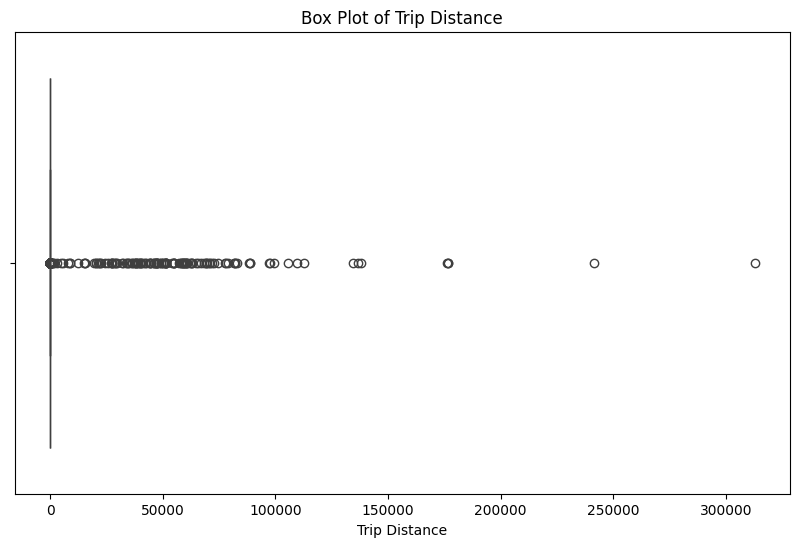

In [25]:
# Create a boxplot for trip_distance
plt.figure(figsize=(10, 6))
sns.boxplot(x=df['trip_distance'])
plt.title('Box Plot of Trip Distance')
plt.xlabel('Trip Distance')
plt.show()

In [26]:
df = df[df['trip_distance']>1]

In [27]:
df[df['trip_distance']>120].sort_values(by='trip_distance', ascending=False).shape

(155, 36)

In [28]:
df = df[df['trip_distance']<120]

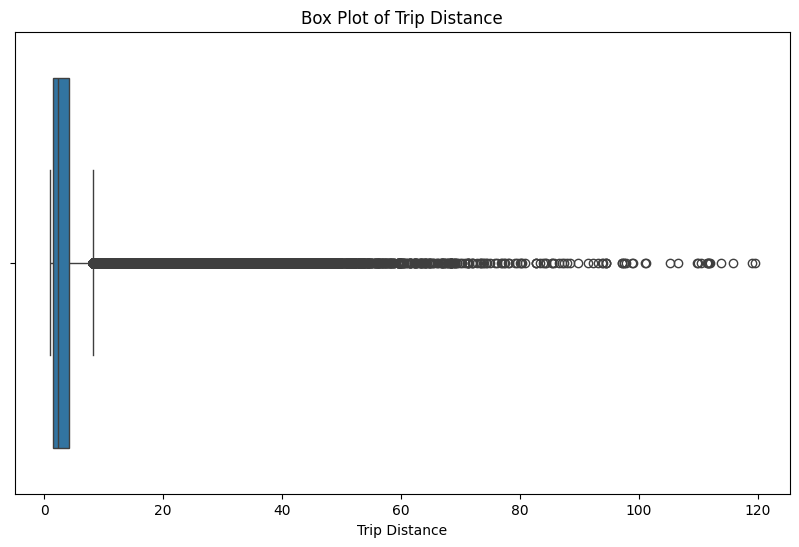

In [29]:
# Create a boxplot for trip_distance
plt.figure(figsize=(10, 6))
sns.boxplot(x=df['trip_distance'])
plt.title('Box Plot of Trip Distance')
plt.xlabel('Trip Distance')
plt.show()

### Fare Amount

In [30]:
df[df['fare_amount']>120].sort_values(by='trip_distance', ascending=False).head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,...,pickup_day_Wednesday,RatecodeID_1.0,RatecodeID_2.0,RatecodeID_3.0,RatecodeID_4.0,RatecodeID_5.0,RatecodeID_6.0,RatecodeID_99.0,pickup_time,day_category
2522757,2,2024-01-28 17:24:07,2024-01-28 19:50:30,1.0,119.459999,N,132,265,2.0,739.400024,...,False,False,False,False,True,False,False,False,Evening,Weekend
2362433,2,2024-01-27 01:30:01,2024-01-27 03:53:02,1.0,118.989998,N,48,265,1.0,260.000000,...,False,False,False,False,False,True,False,False,Midnight,Weekend
770905,2,2024-01-10 11:14:43,2024-01-10 13:06:29,2.0,115.750000,N,132,265,2.0,400.000000,...,True,False,False,False,False,True,False,False,Noon,Weekdays
2933532,2,2024-01-24 23:00:52,2024-01-25 00:58:13,1.0,111.949997,None,164,265,0.0,298.609985,...,True,True,False,False,False,False,False,False,Night,Weekdays
2609633,2,2024-01-29 19:58:16,2024-01-29 21:54:55,4.0,111.769997,N,132,265,1.0,400.000000,...,False,False,False,False,False,True,False,False,Evening,Weekdays


### Feature Creation -- trip_duration

In [31]:
diff = (df['tpep_dropoff_datetime'] - df['tpep_pickup_datetime']).dt.total_seconds()/60
df['trip_duration'] = diff.round(2)

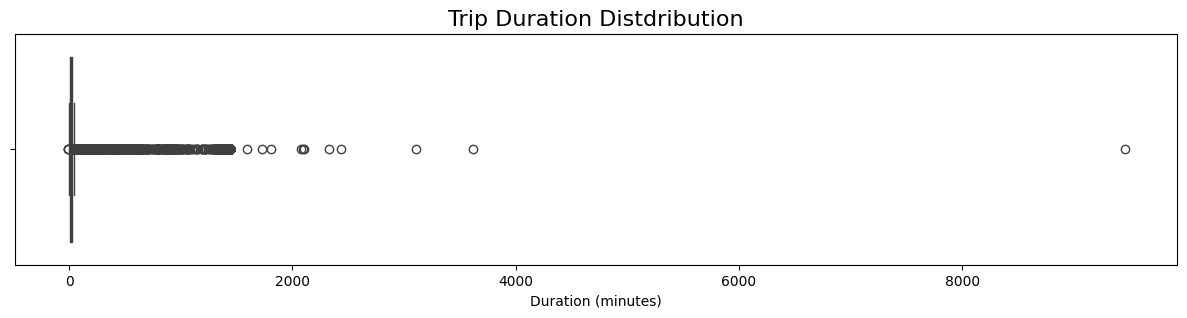

In [32]:
plt.figure(figsize=(15, 3))

sns.boxplot(data=df, x='trip_duration')
plt.xlabel('Duration (minutes)')
plt.title('Trip Duration Distdribution', fontsize=16)


plt.show()

 With the furthest recorded distance, which is 114 miles, when traveled at the lowest average speed in New York City, which is 10 mph, the time required would be 11.4 hours (or about 684 minutes). Therefore, any trip duration exceeding this calculated time can be considered an extreme outlier, as it would be unusually long for a taxi ride. Based on this, any records with durations significantly exceeding 684 minutes can be flagged as extreme outliers, suggesting that these values are likely unnatural or erroneous.

In [33]:
df[df['trip_duration']>700].sort_values(by='trip_duration', ascending=False).head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,...,RatecodeID_1.0,RatecodeID_2.0,RatecodeID_3.0,RatecodeID_4.0,RatecodeID_5.0,RatecodeID_6.0,RatecodeID_99.0,pickup_time,day_category,trip_duration
2111505,2,2024-01-24 17:03:14,2024-01-31 06:38:38,1.0,2.260000,N,237,170,2.0,30.299999,...,True,False,False,False,False,False,False,Evening,Weekdays,9455.40
942462,2,2024-01-12 01:20:50,2024-01-14 13:42:36,1.0,35.700001,N,132,42,2.0,150.399994,...,False,False,True,False,False,False,False,Midnight,Weekdays,3621.77
1159593,2,2024-01-14 10:08:11,2024-01-16 13:54:22,1.0,31.950001,N,220,220,2.0,2221.300049,...,True,False,False,False,False,False,False,Morning,Weekend,3106.18
2219253,2,2024-01-25 18:53:29,2024-01-27 11:32:13,1.0,4.560000,N,140,133,2.0,21.900000,...,True,False,False,False,False,False,False,Evening,Weekdays,2438.73
3042904,2,2024-03-30 18:57:53,2024-04-01 09:42:39,1.0,36.959999,N,231,231,2.0,146.500000,...,True,False,False,False,False,False,False,Evening,Weekend,2324.77


In [34]:
df = df[df['trip_duration']<700]

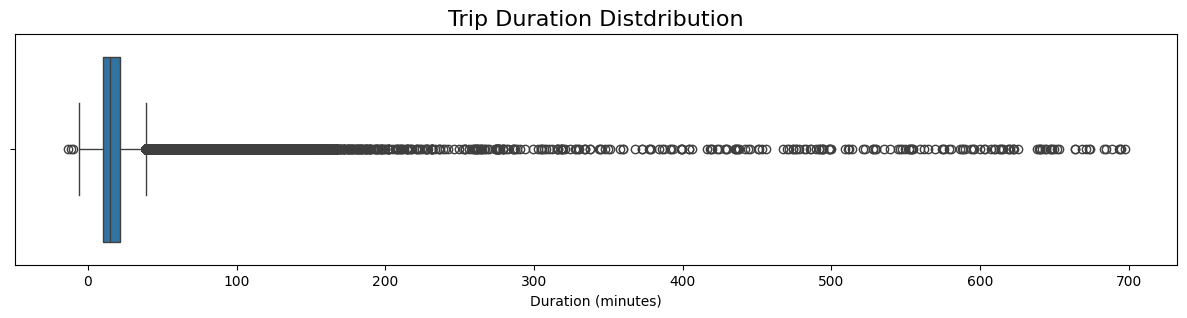

In [35]:
plt.figure(figsize=(15, 3))

sns.boxplot(data=df, x='trip_duration')
plt.xlabel('Duration (minutes)')
plt.title('Trip Duration Distdribution', fontsize=16)


plt.show()

<class 'pandas.core.frame.DataFrame'>
Index: 2612379 entries, 0 to 3723832
Data columns (total 37 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   VendorID               int32         
 1   tpep_pickup_datetime   datetime64[us]
 2   tpep_dropoff_datetime  datetime64[us]
 3   passenger_count        float32       
 4   trip_distance          float32       
 5   store_and_fwd_flag     object        
 6   PULocationID           int32         
 7   DOLocationID           int32         
 8   payment_type           float32       
 9   fare_amount            float32       
 10  extra                  float32       
 11  mta_tax                float32       
 12  tip_amount             float32       
 13  tolls_amount           float32       
 14  improvement_surcharge  float32       
 15  total_amount           float32       
 16  congestion_surcharge   float32       
 17  Airport_fee            float32       
 18  pickup_time            cate

In [36]:
missing_values = df.columns[df.isnull().sum() > 0]
print(missing_values)

Index(['store_and_fwd_flag'], dtype='object')


In [37]:
X = df[['passenger_count', 'trip_distance','PULocationID', 'DOLocationID', 'fare_amount', 'extra',
       'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge',
       'total_amount', 'congestion_surcharge', 'Airport_fee']]
y = df['payment_type']
missing_values = df.columns[df.isnull().sum() > 0]
print(missing_values)

Index(['store_and_fwd_flag'], dtype='object')


In [38]:
# Compute Mutual Information Scores
mi_scores = mutual_info_classif(X, y)
mi_scores = pd.Series(mi_scores, index=X.columns)


In [39]:
# Display MI Scores
print("Mutual Information Scores:")
print(mi_scores.sort_values(ascending=False))


Mutual Information Scores:
total_amount             0.458503
fare_amount              0.453958
tip_amount               0.436047
congestion_surcharge     0.260846
improvement_surcharge    0.253642
mta_tax                  0.227045
passenger_count          0.216777
extra                    0.174404
PULocationID             0.072011
Airport_fee              0.032365
DOLocationID             0.028555
trip_distance            0.024121
tolls_amount             0.012048
dtype: float64


In [40]:
# Split into features and target
X = df[['total_amount', 'fare_amount', 'tip_amount']]  # Replace 'payment_type' with your target column name
y = df['payment_type']

In [41]:
# Initialize models
models = {
    "Logistic Regression": LogisticRegression(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "XGBoost": XGBClassifier(max_depth=5, learning_rate=0.1, n_estimators=20,random_state=42),
    "Decision Tree": DecisionTreeClassifier(random_state=42)
}

In [42]:
# for XGboost, the index should start from 0
if y.min() != 0:
    y = y - y.min()  # Reindex to start from 0

In [45]:
# K-Fold Cross-Validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
# Initialize a dictionary to store confusion matrices
confusion_matrices = {model_name: [] for model_name in models}
# Initialize results dictionary with additional metrics
results = {model_name: {"accuracy": [], "f1_score": [], "precision": [], "recall": []} for model_name in models}

for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    for model_name, model in models.items():
        # Train model
        model.fit(X_train, y_train)
        
        # Predict on test set
        y_pred = model.predict(X_test)

        # Evaluate confusion matrix
        cm = confusion_matrix(y_test, y_pred)
        confusion_matrices[model_name].append(cm)
        
        # Evaluate metrics
        acc = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, average='weighted')  # Use 'weighted' for multiclass
        precision = precision_score(y_test, y_pred, average='weighted')  # Weighted precision
        recall = recall_score(y_test, y_pred, average='weighted')  # Weighted recall
        
        # Append metrics to the results dictionary
        results[model_name]["accuracy"].append(acc)
        results[model_name]["f1_score"].append(f1)
        results[model_name]["precision"].append(precision)
        results[model_name]["recall"].append(recall)

# Display average metrics for each model
for model_name, metrics in results.items():
    print(f"\nModel: {model_name}")
    print(f"Average Accuracy: {np.mean(metrics['accuracy']):.4f}")
    print(f"Average F1-Score: {np.mean(metrics['f1_score']):.4f}")
    print(f"Average Precision: {np.mean(metrics['precision']):.4f}")
    print(f"Average Recall: {np.mean(metrics['recall']):.4f}")

d:\work\DataScience\cs6010_fa2024_project_g06\venv\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
d:\work\DataScience\cs6010_fa2024_project_g06\venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\work\DataScience\cs6010_fa2024_project_g06\venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: Unde


Model: Logistic Regression
Average Accuracy: 0.8330
Average F1-Score: 0.8255
Average Precision: 0.8277
Average Recall: 0.8330

Model: Random Forest
Average Accuracy: 0.9500
Average F1-Score: 0.9478
Average Precision: 0.9504
Average Recall: 0.9500

Model: XGBoost
Average Accuracy: 0.8461
Average F1-Score: 0.8418
Average Precision: 0.8384
Average Recall: 0.8461

Model: Decision Tree
Average Accuracy: 0.9498
Average F1-Score: 0.9477
Average Precision: 0.9500
Average Recall: 0.9498


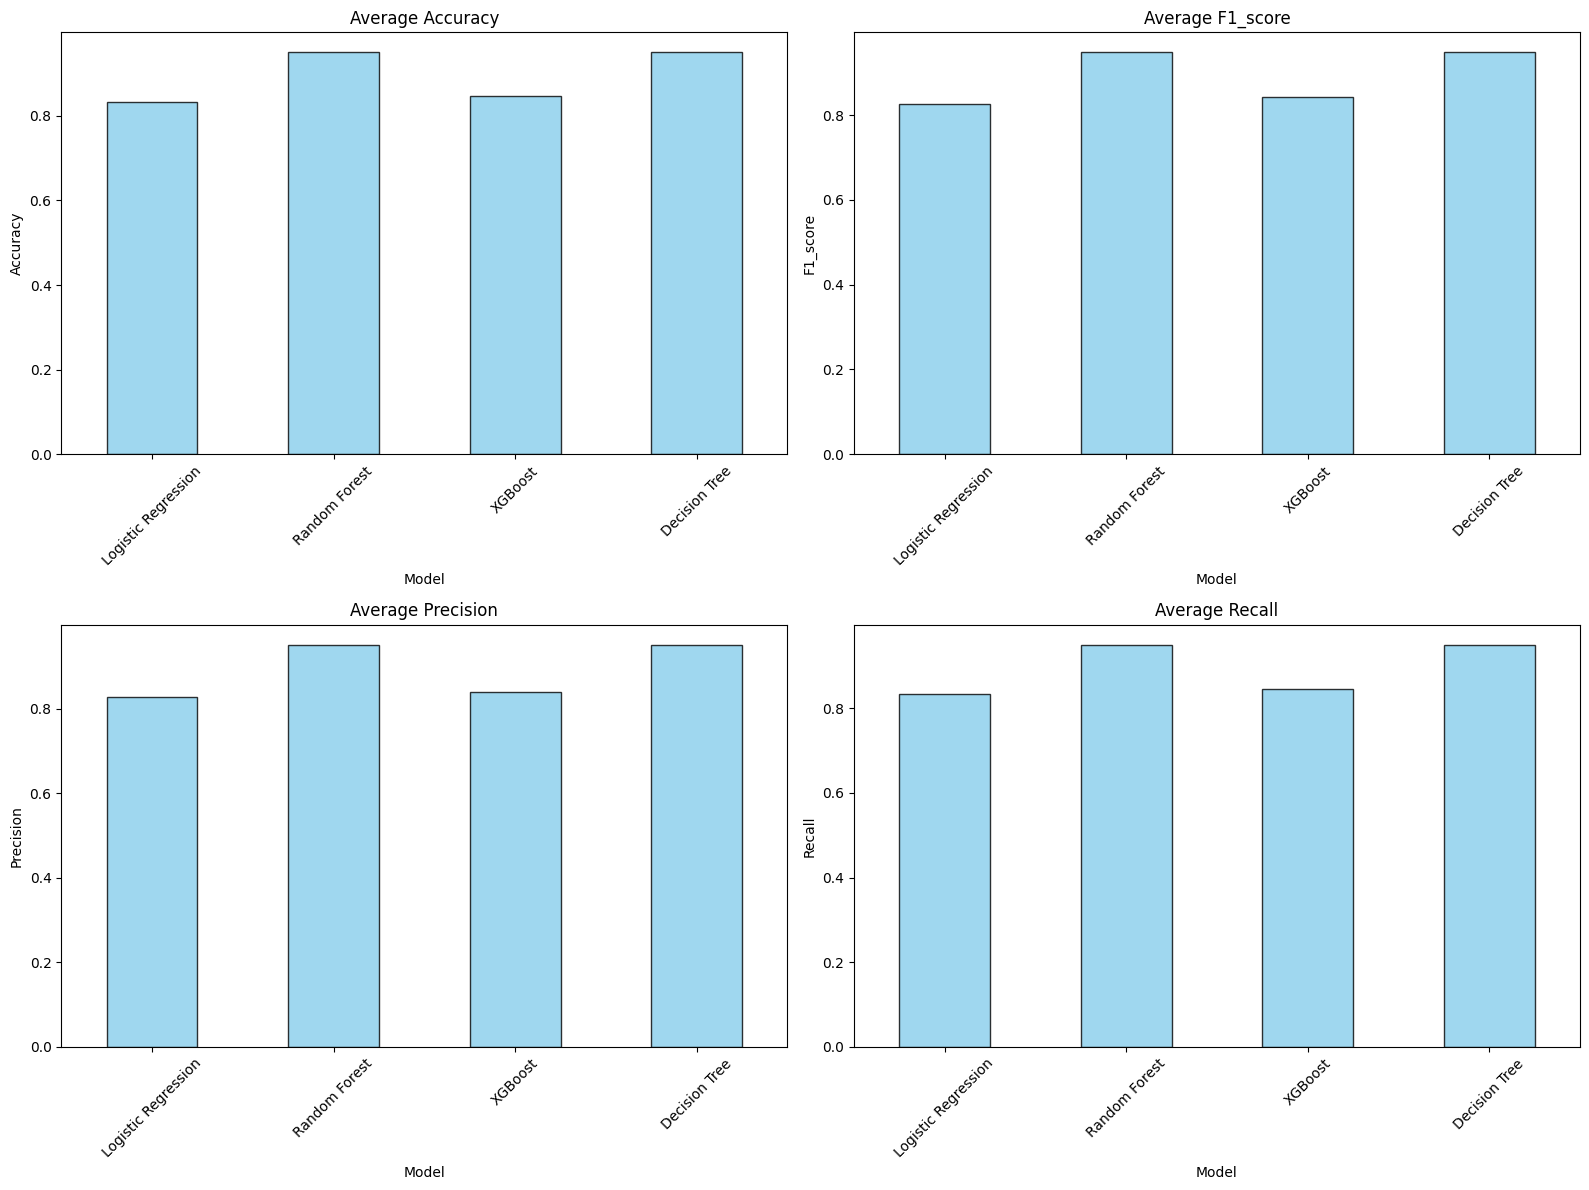

In [49]:
# Metrics to plot
metrics_to_plot = ['accuracy', 'f1_score', 'precision', 'recall']

# Compute average metrics for each model
average_metrics = {
    model_name: {metric: np.mean(metrics[metric]) for metric in metrics_to_plot}
    for model_name, metrics in results.items()
}

# Create a DataFrame for easy visualization
average_metrics_df = pd.DataFrame(average_metrics).T  # Transpose for proper alignment

# Initialize plot
plt.figure(figsize=(16, 12))

for i, metric in enumerate(metrics_to_plot, 1):
    plt.subplot(2, 2, i)  # Create a 2x2 grid for subplots
    average_metrics_df[metric].plot(kind='bar', color='skyblue', edgecolor='black', alpha=0.8)
    plt.title(f'Average {metric.capitalize()}')
    plt.xlabel('Model')
    plt.ylabel(metric.capitalize())
    plt.xticks(rotation=45)

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

In [47]:

# Aggregate confusion matrices
average_confusion_matrices = {model_name: sum(confusion_matrices[model_name]) for model_name in models}

for model_name, cm in average_confusion_matrices.items():
    print(f"\nConfusion Matrix for {model_name}:\n")
    print(cm)


Confusion Matrix for Logistic Regression:

[[ 448307  111224   22322       2       0]
 [  68531 1608341   34819       0       0]
 [ 178847      17  119335       0       0]
 [   3378      11    2498       0       0]
 [   8018       9    6720       0       0]]

Confusion Matrix for Random Forest:

[[ 536943   36921    7949      23      19]
 [   4194 1648816   58577      28      76]
 [    343    1683  295871      94     208]
 [     82      64    5646      81      14]
 [     62     170   14455      34      26]]

Confusion Matrix for XGBoost:

[[ 426896  102413   52541       5       0]
 [  47942 1622796   40952       0       1]
 [ 137459      60  160677       3       0]
 [   2763       6    3118       0       0]
 [   6678      12    8057       0       0]]

Confusion Matrix for Decision Tree:

[[ 538778   35216    7807      21      33]
 [   6124 1647214   58222      42      89]
 [    376    2269  295216     116     222]
 [     91      89    5612      82      13]
 [     68     214   14401   

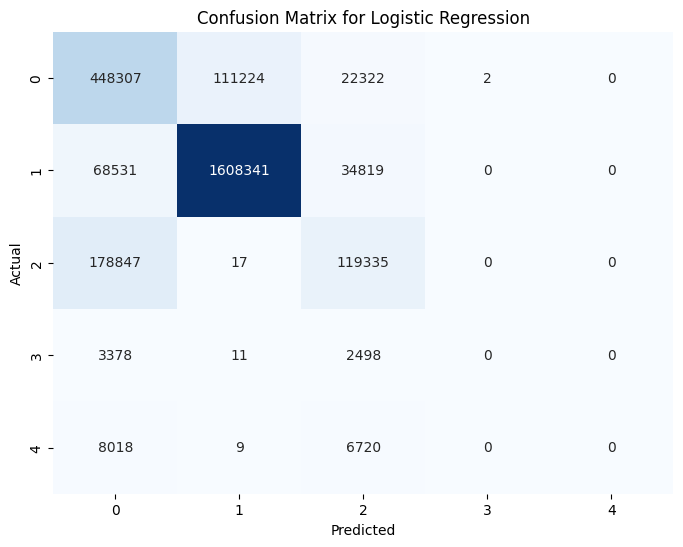

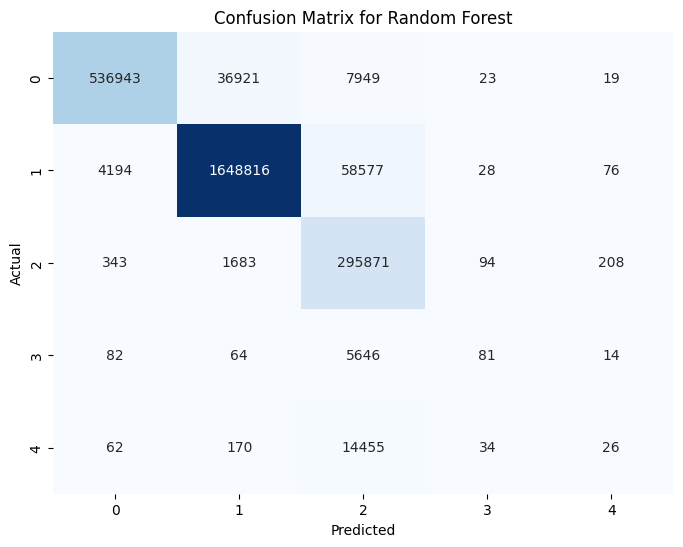

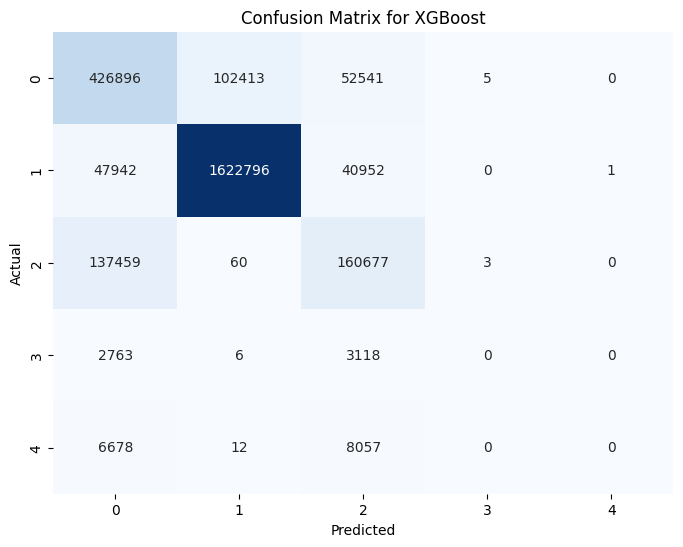

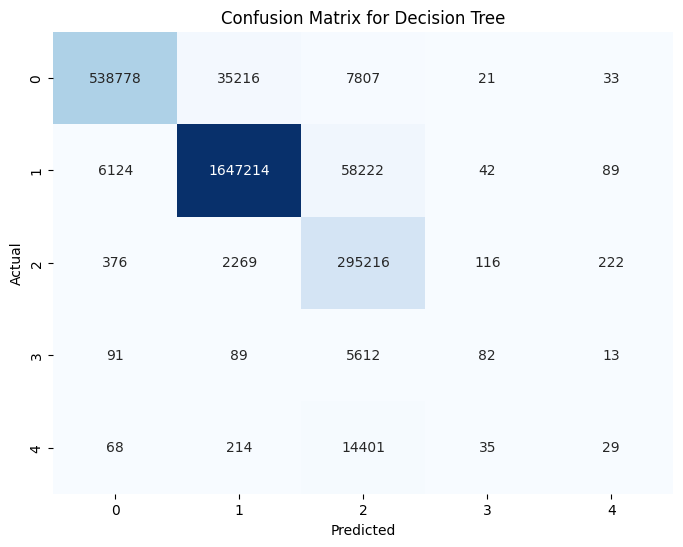

In [48]:
for model_name, cm in average_confusion_matrices.items():
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.title(f"Confusion Matrix for {model_name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()